**Import packages**

In [1]:
!pip install pytictoc

In [2]:
!pip install tensorflow

In [3]:
import random
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pandas as pd
from pytictoc import TicToc
warnings.filterwarnings( "ignore" )

**Load the dataset**

In [4]:
(X_train, y_train), (X_test,y_test) = keras.datasets.mnist.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

**Create helper functions**

In [5]:
def plot_sample_image(X, y):
    plt.figure(figsize = (15,2))
    plt.imshow(X); plt.colorbar();
    classes = ["0","1","2","3","4","5","6","7","8","9"]
    plt.xlabel('Image Label: {}'.format(classes[y]))

def classification_results(X_test,y_test,y_pred_classes):
  from sklearn.metrics import confusion_matrix , classification_report
  import seaborn as sn

  cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred_classes)
  plt.figure(figsize = (7,5))
  sn.heatmap(cm, annot=True, fmt='d', cmap='Greens')
  plt.xlabel('Predicted');
  plt.ylabel('Truth');

  print("Classification Report: \n", classification_report(y_test, y_pred_classes))

def plot_fitting_history(history,filename,dpi):
  epochs = len(history.history['loss'])
  epoch_data = np.arange(1,epochs+1)
  plt.plot(epoch_data,history.history['loss'],'o-')
  plt.plot(epoch_data,history.history['val_loss'],'o--')
  plt.ylabel('Loss')
  plt.xlabel('Epoch sequence' )
  plt.xticks(np.arange(0, epochs + 1, step=1))
  plt.legend(['Training','Validation'])
  plt.savefig(filename, dpi=dpi)
  plt.show()

**Plot sample image**

**Normalize the input data**

In [6]:
X_train = X_train / 255.0
X_test = X_test / 255.0

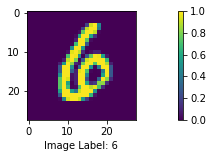

In [7]:
index = np.random.randint(100)
plot_sample_image(X_train[index], y_train[index]);

In [8]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd /content/gdrive/MyDrive/ECE 696B/Project - ECE696B

**Load the models**

In [9]:
%cd C:\Users\nh202\My Drive (nh202@arizona.edu)\ECE 696B\Project - ECE696B
from keras.models import load_model
Linear_MNIST = load_model('Linear_MNIST.h5')
MLP_MNIST = load_model('MLP_MNIST.h5')
CNN_MNIST = load_model('CNN_MNIST.h5')

C:\Users\nh202\My Drive (nh202@arizona.edu)\ECE 696B\Project - ECE696B


# Fast gradient sign method (FGSM) attack

**Function for FGSM attack**

In [10]:
def fgsm_attack(model, x, y_true, eps):

    if len(x.shape) == 2:
        # Create a tensor for the input image to make it compatible with the tensor shape expected by the model
        x_tensor = tf.convert_to_tensor(x[np.newaxis, ...])
    if len(x.shape) == 3:
        x_tensor = tf.convert_to_tensor(x)
    
    # Set tape to watch the input tensor
    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        y_pred = model(x_tensor)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)  
    
    # Calculate the gradient of the loss with respect to the input image
    grads = tape.gradient(loss, x_tensor)
    
    # Calculate the sign of the gradient
    sign = tf.math.sign(grads)    

    # Notes:
    # sign[0] matches the shape of x, sign matches the shape of x_tensor
    # print(sign[0].shape, x.shape, sign.shape, x_tensor.shape)
    
    # Generate the adversarial example by adding the sign of the gradient times epsilon to the input image    
    if len(x.shape) == 2:
        x_adv = x + eps * sign[0]
    if len(x.shape) == 3:
        x_adv = x + eps * sign
    
    # Clip the adversarial example to maintain pixel values in [0,1] range
    x_adv = tf.clip_by_value(x_adv, clip_value_min=0, clip_value_max=1)
    
    return x_adv.numpy()

# Adversarial training of Linear model

In [11]:
indexes = np.arange(0,5000); eps = 0.1
X_train_FGSM_Linear_1 = fgsm_attack(Linear_MNIST,X_train[indexes],y_train[indexes],eps)

indexes = np.arange(5000,7500); eps = 0.2
X_train_FGSM_Linear_2 = fgsm_attack(Linear_MNIST,X_train[indexes],y_train[indexes],eps)

indexes = np.arange(7500,8750); eps = 0.3
X_train_FGSM_Linear_3 = fgsm_attack(Linear_MNIST,X_train[indexes],y_train[indexes],eps)

indexes = np.arange(8750, 9375); eps = 0.4
X_train_FGSM_Linear_4 = fgsm_attack(Linear_MNIST,X_train[indexes],y_train[indexes],eps)

indexes = np.arange(9375, 10000); eps = 0.5
X_train_FGSM_Linear_5 = fgsm_attack(Linear_MNIST,X_train[indexes],y_train[indexes],eps)

X_train_FGSM_Linear = np.concatenate((X_train_FGSM_Linear_1, X_train_FGSM_Linear_2, X_train_FGSM_Linear_3,\
                                X_train_FGSM_Linear_4, X_train_FGSM_Linear_5), axis = 0)

indexes = range(10000)
avg_l2_norm = np.mean(np.sqrt(np.sum((X_train_FGSM_Linear-X_train[indexes])**2, axis=(1,2))))
print("Average l2 distance of the perturbation:", avg_l2_norm)

Average l2 distance of the perturbation: 4.036035548194498


In [12]:
X_train_stack = np.concatenate((X_train, X_train_FGSM_Linear), axis = 0)
y_train_stack = np.concatenate((y_train, y_train[indexes]), axis = 0)

p = np.random.permutation(len(X_train_stack))
X_train_stack, y_train_stack = X_train_stack[p], y_train_stack[p]

X_train_stack.shape, y_train_stack.shape

((70000, 28, 28), (70000,))

In [13]:
import random
import tensorflow as tf
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

Linear_MNIST = models.Sequential([
        layers.Flatten(input_shape=X_train.shape[1:]),
        layers.Dense(10, activation='softmax'),  
    ])

learning_rate =  0.001
Linear_MNIST.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history_C_Linear_FGSM = Linear_MNIST.fit(X_train_stack, y_train_stack, epochs=50, batch_size=32,
            validation_split = 0.2, callbacks = early_callbacks, verbose=1, shuffle = True)

Epoch 1/50
1750/1750 [==============================] - 4s 2ms/step - loss: 0.5063 - accuracy: 0.8676 - val_loss: 0.3430 - val_accuracy: 0.9049
Epoch 2/50
1750/1750 [==============================] - 3s 2ms/step - loss: 0.3045 - accuracy: 0.9165 - val_loss: 0.3022 - val_accuracy: 0.9156
Epoch 3/50
1750/1750 [==============================] - 3s 2ms/step - loss: 0.2752 - accuracy: 0.9241 - val_loss: 0.2888 - val_accuracy: 0.9196
Epoch 4/50
1750/1750 [==============================] - 3s 2ms/step - loss: 0.2595 - accuracy: 0.9281 - val_loss: 0.2760 - val_accuracy: 0.9233
Epoch 5/50
1750/1750 [==============================] - 3s 2ms/step - loss: 0.2499 - accuracy: 0.9308 - val_loss: 0.2706 - val_accuracy: 0.9235
Epoch 6/50
1750/1750 [==============================] - 3s 2ms/step - loss: 0.2417 - accuracy: 0.9333 - val_loss: 0.2652 - val_accuracy: 0.9279
Epoch 7/50
1750/1750 [==============================] - 3s 2ms/step - loss: 0.2364 - accuracy: 0.9348 - val_loss: 0.2649 - val_accuracy:

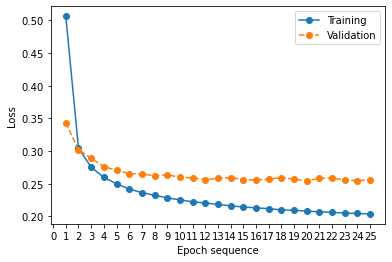

In [17]:
filename = 'FGSM Adversarial Training history MNIST [Linear]'+'.png'
plot_fitting_history(history_C_Linear_FGSM, filename, dpi = 100)

313/313 [==============================] - 0s 874us/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.97      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.87      0.93      0.90      1010
           4       0.94      0.93      0.93       982
           5       0.92      0.85      0.89       892
           6       0.95      0.95      0.95       958
           7       0.94      0.91      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.90      0.92      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



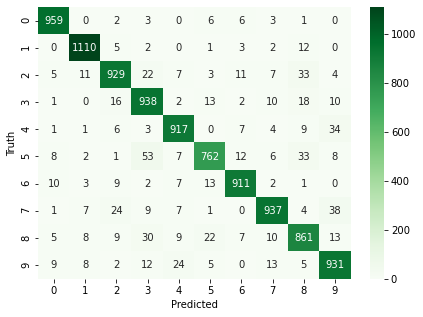

In [18]:
y_pred = Linear_MNIST.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]
classification_results(X_test,y_test,y_pred_classes)

In [19]:
Linear_MNIST.save('Linear_MNIST_FGSM_trained.h5')

# Adversarial training of MLP model

In [21]:
indexes = np.arange(0,5000); eps = 0.1
X_train_FGSM_MLP_1 = fgsm_attack(MLP_MNIST,X_train[indexes],y_train[indexes],eps)

indexes = np.arange(5000,7500); eps = 0.2
X_train_FGSM_MLP_2 = fgsm_attack(MLP_MNIST,X_train[indexes],y_train[indexes],eps)

indexes = np.arange(7500,8750); eps = 0.3
X_train_FGSM_MLP_3 = fgsm_attack(MLP_MNIST,X_train[indexes],y_train[indexes],eps)

indexes = np.arange(8750, 9375); eps = 0.4
X_train_FGSM_MLP_4 = fgsm_attack(MLP_MNIST,X_train[indexes],y_train[indexes],eps)

indexes = np.arange(9375, 10000); eps = 0.5
X_train_FGSM_MLP_5 = fgsm_attack(MLP_MNIST,X_train[indexes],y_train[indexes],eps)

X_train_FGSM_MLP = np.concatenate((X_train_FGSM_MLP_1, X_train_FGSM_MLP_2, X_train_FGSM_MLP_3,\
                                X_train_FGSM_MLP_4, X_train_FGSM_MLP_5), axis = 0)

indexes = range(10000)
avg_l2_norm = np.mean(np.sqrt(np.sum((X_train_FGSM_MLP-X_train[indexes])**2, axis=(1,2))))
print("Average l2 distance of the perturbation:", avg_l2_norm)

Average l2 distance of the perturbation: 4.077626737972499


In [22]:
X_train_stack = np.concatenate((X_train, X_train_FGSM_MLP), axis = 0)
y_train_stack = np.concatenate((y_train, y_train[indexes]), axis = 0)

p = np.random.permutation(len(X_train_stack))
X_train_stack, y_train_stack = X_train_stack[p], y_train_stack[p]

X_train_stack.shape, y_train_stack.shape

((70000, 28, 28), (70000,))

In [23]:
import random
import tensorflow as tf
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

MLP_MNIST = models.Sequential([
        layers.Flatten(input_shape=X_train.shape[1:]),
        layers.Dense(2**6, activation='relu'),
        layers.Dense(10, activation='softmax')    
    ])

learning_rate =  0.001
MLP_MNIST.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


early_callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history_C_MLP_FGSM = MLP_MNIST.fit(X_train_stack, y_train_stack, epochs=50, batch_size=32,
            validation_split = 0.2, callbacks = early_callbacks, verbose=1, shuffle = True)

Epoch 1/50
1750/1750 [==============================] - 4s 2ms/step - loss: 0.3298 - accuracy: 0.9074 - val_loss: 0.1878 - val_accuracy: 0.9456
Epoch 2/50
1750/1750 [==============================] - 4s 3ms/step - loss: 0.1533 - accuracy: 0.9564 - val_loss: 0.1485 - val_accuracy: 0.9558
Epoch 3/50
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1098 - accuracy: 0.9692 - val_loss: 0.1334 - val_accuracy: 0.9601
Epoch 4/50
1750/1750 [==============================] - 4s 2ms/step - loss: 0.0869 - accuracy: 0.9741 - val_loss: 0.1030 - val_accuracy: 0.9681
Epoch 5/50
1750/1750 [==============================] - 5s 3ms/step - loss: 0.0703 - accuracy: 0.9796 - val_loss: 0.1079 - val_accuracy: 0.9663
Epoch 6/50
1750/1750 [==============================] - 4s 2ms/step - loss: 0.0589 - accuracy: 0.9825 - val_loss: 0.0954 - val_accuracy: 0.9699
Epoch 7/50
1750/1750 [==============================] - 4s 2ms/step - loss: 0.0501 - accuracy: 0.9849 - val_loss: 0.0997 - val_accuracy:

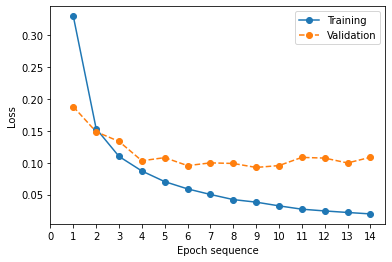

In [24]:
filename = 'FGSM Adversarial Training history MNIST [MLP]'+'.png'
plot_fitting_history(history_C_MLP_FGSM, filename, dpi = 100)

313/313 [==============================] - 0s 1ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.96      0.98      0.97       982
           5       0.96      0.97      0.96       892
           6       0.97      0.97      0.97       958
           7       0.97      0.98      0.97      1028
           8       0.98      0.95      0.97       974
           9       0.98      0.94      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



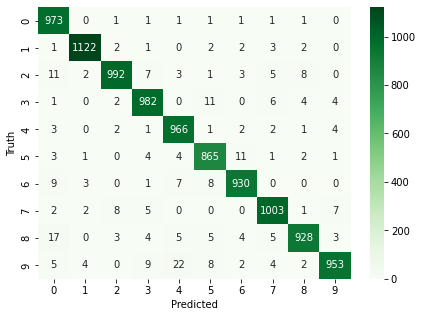

In [25]:
y_pred = MLP_MNIST.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]
classification_results(X_test,y_test,y_pred_classes)

In [26]:
MLP_MNIST.save('MLP_MNIST_FGSM_trained.h5')

# Adversarial training of CNN model

In [27]:
indexes = np.arange(0,5000); eps = 0.1
X_train_FGSM_CNN_1 = fgsm_attack(CNN_MNIST,X_train[indexes],y_train[indexes],eps)

indexes = np.arange(5000,7500); eps = 0.2
X_train_FGSM_CNN_2 = fgsm_attack(CNN_MNIST,X_train[indexes],y_train[indexes],eps)

indexes = np.arange(7500,8750); eps = 0.3
X_train_FGSM_CNN_3 = fgsm_attack(CNN_MNIST,X_train[indexes],y_train[indexes],eps)

indexes = np.arange(8750, 9375); eps = 0.4
X_train_FGSM_CNN_4 = fgsm_attack(CNN_MNIST,X_train[indexes],y_train[indexes],eps)

indexes = np.arange(9375, 10000); eps = 0.5
X_train_FGSM_CNN_5 = fgsm_attack(CNN_MNIST,X_train[indexes],y_train[indexes],eps)

X_train_FGSM_CNN = np.concatenate((X_train_FGSM_CNN_1, X_train_FGSM_CNN_2, X_train_FGSM_CNN_3,\
                                X_train_FGSM_CNN_4, X_train_FGSM_CNN_5), axis = 0)

indexes = range(10000)
avg_l2_norm = np.mean(np.sqrt(np.sum((X_train_FGSM_CNN-X_train[indexes])**2, axis=(1,2))))
print("Average l2 distance of the perturbation:", avg_l2_norm)

Average l2 distance of the perturbation: 4.09008555539465


In [28]:
X_train_stack = np.concatenate((X_train, X_train_FGSM_CNN), axis = 0)
y_train_stack = np.concatenate((y_train, y_train[indexes]), axis = 0)

p = np.random.permutation(len(X_train_stack))
X_train_stack, y_train_stack = X_train_stack[p], y_train_stack[p]

X_train_stack.shape, y_train_stack.shape

((70000, 28, 28), (70000,))

In [29]:
import random
import tensorflow as tf
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

CNN_MNIST = models.Sequential([
    layers.Conv2D(filters=2**4, kernel_size=(3, 3), padding = 'same', 
                  activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(2**4, activation='relu'),
    layers.Dense(10, activation='softmax')
])

learning_rate =  0.001
CNN_MNIST.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history_C_CNN_FGSM = CNN_MNIST.fit(X_train_stack, y_train_stack, epochs=50, batch_size=32,
            validation_split = 0.2, callbacks = early_callbacks, verbose=1, shuffle = True)

Epoch 1/50
1750/1750 [==============================] - 21s 12ms/step - loss: 0.3232 - accuracy: 0.9024 - val_loss: 0.1417 - val_accuracy: 0.9594
Epoch 2/50
1750/1750 [==============================] - 22s 12ms/step - loss: 0.1070 - accuracy: 0.9687 - val_loss: 0.0950 - val_accuracy: 0.9721
Epoch 3/50
1750/1750 [==============================] - 20s 11ms/step - loss: 0.0766 - accuracy: 0.9771 - val_loss: 0.0844 - val_accuracy: 0.9739
Epoch 4/50
1750/1750 [==============================] - 19s 11ms/step - loss: 0.0613 - accuracy: 0.9817 - val_loss: 0.0686 - val_accuracy: 0.9786
Epoch 5/50
1750/1750 [==============================] - 21s 12ms/step - loss: 0.0524 - accuracy: 0.9839 - val_loss: 0.0747 - val_accuracy: 0.9771
Epoch 6/50
1750/1750 [==============================] - 20s 11ms/step - loss: 0.0451 - accuracy: 0.9867 - val_loss: 0.0733 - val_accuracy: 0.9774
Epoch 7/50
1750/1750 [==============================] - 19s 11ms/step - loss: 0.0396 - accuracy: 0.9876 - val_loss: 0.0727 -

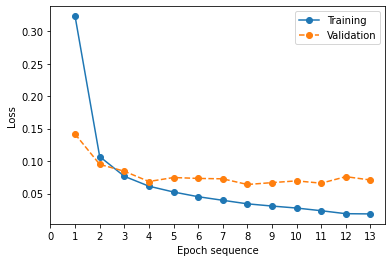

In [30]:
filename = 'FGSM Adversarial Training history MNIST [CNN]'+'.png'
plot_fitting_history(history_C_CNN_FGSM, filename, dpi = 100)

313/313 [==============================] - 1s 4ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.97      0.98       892
           6       0.99      0.97      0.98       958
           7       0.99      0.97      0.98      1028
           8       0.95      0.99      0.97       974
           9       0.99      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



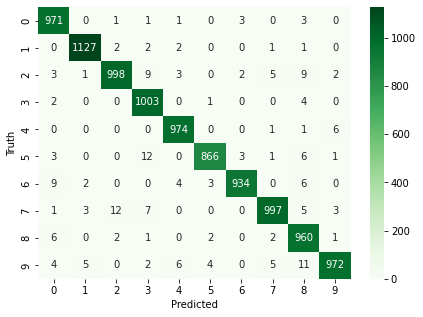

In [31]:
y_pred = CNN_MNIST.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]
classification_results(X_test,y_test,y_pred_classes)

In [32]:
CNN_MNIST.save('CNN_MNIST_FGSM_trained.h5')

# Evaluate performance of adversarial training

In [20]:
%cd C:\Users\nh202\My Drive (nh202@arizona.edu)\ECE 696B\Project - ECE696B
from keras.models import load_model
Linear_MNIST = load_model('Linear_MNIST_FGSM_trained.h5')
MLP_MNIST = load_model('MLP_MNIST_FGSM_trained.h5')
CNN_MNIST = load_model('CNN_MNIST_FGSM_trained.h5')

C:\Users\nh202\My Drive (nh202@arizona.edu)\ECE 696B\Project - ECE696B


In [21]:
indexes = range(1000)
print('Test accuracy on unperturbed data')
Linear_MNIST.evaluate(X_test[indexes],y_test[indexes])
MLP_MNIST.evaluate(X_test[indexes],y_test[indexes])
CNN_MNIST.evaluate(X_test[indexes],y_test[indexes])
print('\n')

Test accuracy on unperturbed data
32/32 [==============================] - 0s 3ms/step - loss: 0.0706 - accuracy: 0.9790




In [22]:
%cd C:\Users\nh202\OneDrive - University of Arizona\Adversairal Examples - ECE 696B\FGSM

C:\Users\nh202\OneDrive - University of Arizona\Adversairal Examples - ECE 696B\FGSM


**Performance on adversarial examples**

In [23]:
indexes = range(1000)
for eps in np.arange(0.1,1.1,0.1):
    
  print(f'eps value: {np.round(eps,1)}')

  np_array_filename = 'MNIST_FGSM_'+ str(len(indexes)) +'_adv_examples_eps_'+ str(round(eps,1)) + '.npz'
  data = np.load(np_array_filename)

  # access the arrays using their keys
  X_test_FGSM_Linear = data['X_test_FGSM_Linear']
  X_test_FGSM_MLP = data['X_test_FGSM_MLP']
  X_test_FGSM_CNN = data['X_test_FGSM_CNN']

  stored_results = []
  print('\n')
  print('Test accuracy on perturbed data targeted for Linear model')
  avg_l2_norm_Linear = np.mean(np.sqrt(np.sum((X_test_FGSM_Linear-X_test[:len(indexes)])**2, axis=(1,2))))
  stored_results.append(avg_l2_norm_Linear)
  _, accuracy = Linear_MNIST.evaluate(X_test_FGSM_Linear[indexes],y_test[indexes])
  stored_results.append(accuracy)
  _, accuracy = MLP_MNIST.evaluate(X_test_FGSM_Linear[indexes],y_test[indexes])
  stored_results.append(accuracy)
  _, accuracy = CNN_MNIST.evaluate(X_test_FGSM_Linear[indexes],y_test[indexes])
  stored_results.append(accuracy)
  print('\n')
  print('Test accuracy on perturbed data targeted for MLP model')
  avg_l2_norm_MLP = np.mean(np.sqrt(np.sum((X_test_FGSM_MLP-X_test[:len(indexes)])**2, axis=(1,2))))
  stored_results.append(avg_l2_norm_MLP)
  _, accuracy = Linear_MNIST.evaluate(X_test_FGSM_MLP[indexes],y_test[indexes])
  stored_results.append(accuracy)
  _, accuracy = MLP_MNIST.evaluate(X_test_FGSM_MLP[indexes],y_test[indexes])
  stored_results.append(accuracy)
  _, accuracy = CNN_MNIST.evaluate(X_test_FGSM_MLP[indexes],y_test[indexes])
  stored_results.append(accuracy)
  print('\n')
  print('Test accuracy on perturbed data targeted for CNN model')
  avg_l2_norm_CNN = np.mean(np.sqrt(np.sum((X_test_FGSM_CNN-X_test[:len(indexes)])**2, axis=(1,2))))
  stored_results.append(avg_l2_norm_CNN)
  _, accuracy = Linear_MNIST.evaluate(X_test_FGSM_CNN[indexes],y_test[indexes])
  stored_results.append(accuracy)
  _, accuracy = MLP_MNIST.evaluate(X_test_FGSM_CNN[indexes],y_test[indexes])
  stored_results.append(accuracy)
  _, accuracy = CNN_MNIST.evaluate(X_test_FGSM_CNN[indexes],y_test[indexes])
  stored_results.append(accuracy)
  print()

  stored_results = np.array(stored_results)
  stored_results = stored_results.reshape(-1,4)
  df = pd.DataFrame(stored_results, columns = ['avg_l2_norm','Linear_MNIST_test_accuray',\
                                   'MLP_MNIST_test_accuray','CNN_MNIST_test_accuray'])

  filename = 'Post training Adversarial_Attacks_MNIST_'+ str(len(indexes)) +' [FGSM Attack - eps '+ str(round(eps,1)) + '].csv'
  df.to_csv(filename, index=False)

eps value: 0.1


Test accuracy on perturbed data targeted for Linear model
32/32 [==============================] - 0s 3ms/step - loss: 0.3167 - accuracy: 0.9060


Test accuracy on perturbed data targeted for MLP model
32/32 [==============================] - 0s 3ms/step - loss: 0.2633 - accuracy: 0.9280


Test accuracy on perturbed data targeted for CNN model
32/32 [==============================] - 0s 4ms/step - loss: 0.0317 - accuracy: 0.9910

eps value: 0.2


Test accuracy on perturbed data targeted for Linear model
32/32 [==============================] - 0s 4ms/step - loss: 2.2858 - accuracy: 0.5500


Test accuracy on perturbed data targeted for MLP model
32/32 [==============================] - 0s 5ms/step - loss: 1.5386 - accuracy: 0.6630


Test accuracy on perturbed data targeted for CNN model
32/32 [==============================] - 0s 3ms/step - loss: 0.0209 - accuracy: 0.9940

eps value: 0.3


Test accuracy on perturbed data targeted for Linear model
32/32 [================

32/32 [==============================] - 0s 5ms/step - loss: 39.1514 - accuracy: 0.1000


Test accuracy on perturbed data targeted for CNN model
32/32 [==============================] - 0s 6ms/step - loss: 0.6762 - accuracy: 0.9380

eps value: 1.0


Test accuracy on perturbed data targeted for Linear model
32/32 [==============================] - 0s 4ms/step - loss: 54.9681 - accuracy: 0.0770


Test accuracy on perturbed data targeted for MLP model
32/32 [==============================] - 0s 5ms/step - loss: 44.0794 - accuracy: 0.0970


Test accuracy on perturbed data targeted for CNN model
32/32 [==============================] - 0s 5ms/step - loss: 0.8406 - accuracy: 0.9350



# Compile the results into a dataframe

In [24]:
target_models = []
for i in range(10):
    target_models.append('Linear')
    target_models.append('MLP')    
    target_models.append('CNN') 
target_models = np.array(target_models).reshape(-1,1)

In [25]:
eps_values = []
for eps in np.arange(0.1,1.1,0.1):
    eps_values.append(eps)
    eps_values.append(eps)    
    eps_values.append(eps) 
eps_values = np.array(eps_values).reshape(-1,1)

In [26]:
df_all = pd.DataFrame()
for eps in np.arange(0.1,1.1,0.1):
    filename = 'Post training Adversarial_Attacks_MNIST_'+ str(len(indexes)) +' [FGSM Attack - eps '+ str(round(eps,1)) + '].csv'
    df = pd.read_csv(filename)
    df_all = pd.concat([df_all, df], ignore_index=True)
df_all['Target model'] = target_models
df_all['eps value'] = eps_values
df_all = df_all[['eps value', 'Target model', 'avg_l2_norm', 'Linear_MNIST_test_accuray', 'MLP_MNIST_test_accuray',
       'CNN_MNIST_test_accuray']]
df_all.to_csv('Post training Adversarial_Attacks_MNIST [FGSM Attack].csv', index=False)
df_all

,eps value,Target model,avg_l2_norm,Linear_MNIST_test_accuray,MLP_MNIST_test_accuray,CNN_MNIST_test_accuray
0,0.1,Linear,2.104669,0.998,0.924,0.906
1,0.1,MLP,2.130851,0.528,0.987,0.928
2,0.1,CNN,2.139995,0.784,0.936,0.991
3,0.2,Linear,4.174779,1.000,0.760,0.550
4,0.2,MLP,4.227887,0.200,0.993,0.663
5,0.2,CNN,4.248348,0.503,0.738,0.994
6,0.3,Linear,6.217968,1.000,0.445,0.203
7,0.3,MLP,6.298463,0.082,0.991,0.371
8,0.3,CNN,6.331492,0.293,0.491,0.994
9,0.4,Linear,8.237682,1.000,0.238,0.108


# Prepare the plots

Test accuracy on unperturbed data
32/32 [==============================] - 0s 2ms/step - loss: 0.0706 - accuracy: 0.9790
Test accuracy on unperturbed data
32/32 [==============================] - 0s 2ms/step - loss: 0.0706 - accuracy: 0.9790


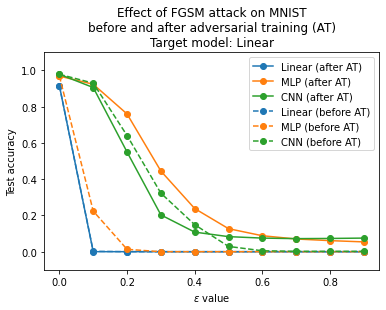

In [43]:
df_all = pd.read_csv('Post training Adversarial_Attacks_MNIST [FGSM Attack].csv')
df_Linear = df_all[df_all['Target model']=='Linear']
df_Linear = df_Linear.shift(1)
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_MNIST.evaluate(X_test[indexes],y_test[indexes]);
df_Linear.iloc[0] = [0, '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df_Linear
plt.plot(df_Linear['eps value'],df_Linear['Linear_MNIST_test_accuray'],'o-')
plt.plot(df_Linear['eps value'],df_Linear['MLP_MNIST_test_accuray'],'o-')
plt.plot(df_Linear['eps value'],df_Linear['CNN_MNIST_test_accuray'],'o-')

df_all = pd.read_csv('Adversarial_Attacks_MNIST [FGSM Attack].csv')
df_Linear = df_all[df_all['Target model']=='Linear']
df_Linear = df_Linear.shift(1)
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_MNIST.evaluate(X_test[indexes],y_test[indexes]);
df_Linear.iloc[0] = [0, '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df_Linear
plt.plot(df_Linear['eps value'],df_Linear['Linear_MNIST_test_accuray'],'o--', color = 'C0')
plt.plot(df_Linear['eps value'],df_Linear['MLP_MNIST_test_accuray'],'o--', color = 'C1')
plt.plot(df_Linear['eps value'],df_Linear['CNN_MNIST_test_accuray'],'o--', color = 'C2')

plt.xlabel('$\epsilon$ value')
plt.ylabel('Test accuracy')
plt.ylim([-0.1, 1.1])
# plt.legend(['Linear (after AT)', 'Linear (before AT)'])
plt.legend(['Linear (after AT)', 'MLP (after AT)','CNN (after AT)', \
            'Linear (before AT)', 'MLP (before AT)','CNN (before AT)'])
plt.title('Effect of FGSM attack on MNIST\nbefore and after adversarial training (AT)\nTarget model: Linear')
plt.savefig('Post training Effect of FGSM attack on MNIST for Linear model [eps]', dpi=600)
plt.show()

Test accuracy on unperturbed data
32/32 [==============================] - 0s 3ms/step - loss: 0.0706 - accuracy: 0.9790
Test accuracy on unperturbed data
32/32 [==============================] - 0s 3ms/step - loss: 0.0706 - accuracy: 0.9790


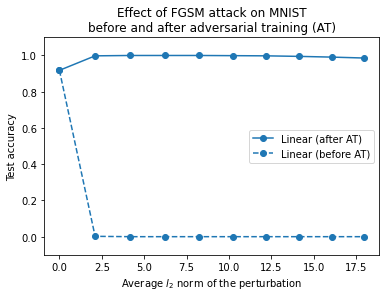

In [31]:
df_all = pd.read_csv('Post training Adversarial_Attacks_MNIST [FGSM Attack].csv')
df_Linear = df_all[df_all['Target model']=='Linear']
df_Linear = df_Linear.shift(1)
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_MNIST.evaluate(X_test[indexes],y_test[indexes]);
df_Linear.iloc[0] = ['-', '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df_Linear
# plt.plot(df_Linear['avg_l2_norm'],df_Linear['Linear_MNIST_test_accuray'],'o-')
# plt.plot(df_Linear['avg_l2_norm'],df_Linear['MLP_MNIST_test_accuray'],'o-')
# plt.plot(df_Linear['avg_l2_norm'],df_Linear['CNN_MNIST_test_accuray'],'o-')
plt.plot(df_Linear['avg_l2_norm'],df_Linear['Linear_MNIST_test_accuray'],'o-', color = 'C0')

df_all = pd.read_csv('Adversarial_Attacks_MNIST [FGSM Attack].csv')
df_Linear = df_all[df_all['Target model']=='Linear']
df_Linear = df_Linear.shift(1)
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_MNIST.evaluate(X_test[indexes],y_test[indexes]);
df_Linear.iloc[0] = ['-', '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df_Linear
plt.plot(df_Linear['avg_l2_norm'],df_Linear['Linear_MNIST_test_accuray'],'o--', color = 'C0')
# plt.plot(df_Linear['avg_l2_norm'],df_Linear['MLP_MNIST_test_accuray'],'o--', color = 'C1')
# plt.plot(df_Linear['avg_l2_norm'],df_Linear['CNN_MNIST_test_accuray'],'o--', color = 'C2')

plt.xlabel('Average $l_2$ norm of the perturbation')
plt.ylabel('Test accuracy')
plt.ylim([-0.1, 1.1])
plt.legend(['Linear (after AT)', 'Linear (before AT)'])
# plt.legend(['Linear (after AT)', 'MLP (after AT)','CNN (after AT)', \
#             'Linear (before AT)', 'MLP (before AT)','CNN (before AT)'])
plt.title('Effect of FGSM attack on MNIST\nbefore and after adversarial training (AT)')#\nTarget model: Linear')
plt.savefig('Post training Effect of FGSM attack on MNIST for Linear model [l2 norm]_1', dpi=600)
plt.show()

Test accuracy on unperturbed data
32/32 [==============================] - 0s 3ms/step - loss: 0.0706 - accuracy: 0.9790
Test accuracy on unperturbed data
32/32 [==============================] - 0s 3ms/step - loss: 0.0706 - accuracy: 0.9790


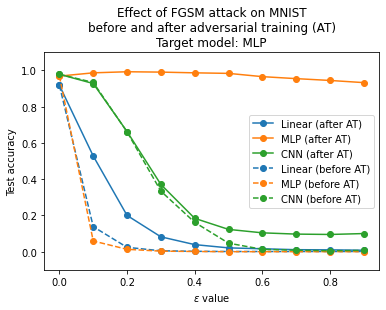

In [28]:
df_all = pd.read_csv('Post training Adversarial_Attacks_MNIST [FGSM Attack].csv')
df_MLP = df_all[df_all['Target model']=='MLP']
df_MLP = df_MLP.shift(1)
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_MNIST.evaluate(X_test[indexes],y_test[indexes]);
df_MLP.iloc[0] = [0, '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df_MLP
plt.plot(df_MLP['eps value'],df_MLP['Linear_MNIST_test_accuray'],'o-')
plt.plot(df_MLP['eps value'],df_MLP['MLP_MNIST_test_accuray'],'o-')
plt.plot(df_MLP['eps value'],df_MLP['CNN_MNIST_test_accuray'],'o-')

df_all = pd.read_csv('Adversarial_Attacks_MNIST [FGSM Attack].csv')
df_MLP = df_all[df_all['Target model']=='MLP']
df_MLP = df_MLP.shift(1)
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_MNIST.evaluate(X_test[indexes],y_test[indexes]);
df_MLP.iloc[0] = [0, '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df_MLP
plt.plot(df_MLP['eps value'],df_MLP['Linear_MNIST_test_accuray'],'o--', color = 'C0')
plt.plot(df_MLP['eps value'],df_MLP['MLP_MNIST_test_accuray'],'o--', color = 'C1')
plt.plot(df_MLP['eps value'],df_MLP['CNN_MNIST_test_accuray'],'o--', color = 'C2')

plt.xlabel('$\epsilon$ value')
plt.ylabel('Test accuracy')
plt.ylim([-0.1, 1.1])
# plt.legend(['MLP (after AT)', 'MLP (before AT)'])
plt.legend(['Linear (after AT)', 'MLP (after AT)','CNN (after AT)', \
            'Linear (before AT)', 'MLP (before AT)','CNN (before AT)'])
plt.title('Effect of FGSM attack on MNIST\nbefore and after adversarial training (AT)\nTarget model: MLP')
plt.savefig('Post training Effect of FGSM attack on MNIST for MLP model [eps]', dpi=600)
plt.show()

Test accuracy on unperturbed data
32/32 [==============================] - 0s 3ms/step - loss: 0.0706 - accuracy: 0.9790
Test accuracy on unperturbed data
32/32 [==============================] - 0s 3ms/step - loss: 0.0706 - accuracy: 0.9790


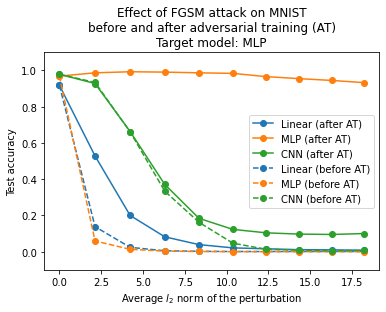

In [29]:
df_all = pd.read_csv('Post training Adversarial_Attacks_MNIST [FGSM Attack].csv')
df_MLP = df_all[df_all['Target model']=='MLP']
df_MLP = df_MLP.shift(1)
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_MNIST.evaluate(X_test[indexes],y_test[indexes]);
df_MLP.iloc[0] = ['-', '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df_MLP
plt.plot(df_MLP['avg_l2_norm'],df_MLP['Linear_MNIST_test_accuray'],'o-')
plt.plot(df_MLP['avg_l2_norm'],df_MLP['MLP_MNIST_test_accuray'],'o-')
plt.plot(df_MLP['avg_l2_norm'],df_MLP['CNN_MNIST_test_accuray'],'o-')

df_all = pd.read_csv('Adversarial_Attacks_MNIST [FGSM Attack].csv')
df_MLP = df_all[df_all['Target model']=='MLP']
df_MLP = df_MLP.shift(1)
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_MNIST.evaluate(X_test[indexes],y_test[indexes]);
df_MLP.iloc[0] = ['-', '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df_MLP
plt.plot(df_MLP['avg_l2_norm'],df_MLP['Linear_MNIST_test_accuray'],'o--', color = 'C0')
plt.plot(df_MLP['avg_l2_norm'],df_MLP['MLP_MNIST_test_accuray'],'o--', color = 'C1')
plt.plot(df_MLP['avg_l2_norm'],df_MLP['CNN_MNIST_test_accuray'],'o--', color = 'C2')

plt.xlabel('Average $l_2$ norm of the perturbation')
plt.ylabel('Test accuracy')
plt.ylim([-0.1, 1.1])
# plt.legend(['MLP (after AT)', 'MLP (before AT)'])
plt.legend(['Linear (after AT)', 'MLP (after AT)','CNN (after AT)', \
            'Linear (before AT)', 'MLP (before AT)','CNN (before AT)'])
plt.title('Effect of FGSM attack on MNIST\nbefore and after adversarial training (AT)\nTarget model: MLP')
plt.savefig('Post training Effect of FGSM attack on MNIST for MLP model [l2 norm]', dpi=600)
plt.show()

Test accuracy on unperturbed data
32/32 [==============================] - 0s 2ms/step - loss: 0.0706 - accuracy: 0.9790
Test accuracy on unperturbed data
32/32 [==============================] - 0s 2ms/step - loss: 0.0706 - accuracy: 0.9790


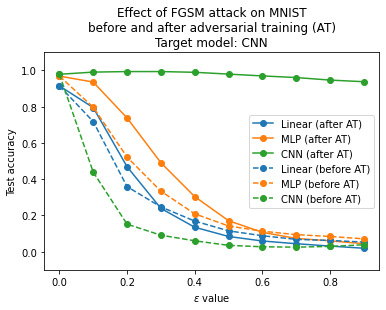

In [44]:
df_all = pd.read_csv('Post training Adversarial_Attacks_MNIST [FGSM Attack].csv')
df_CNN = df_all[df_all['Target model']=='CNN']
df_CNN = df_CNN.shift(1)
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_MNIST.evaluate(X_test[indexes],y_test[indexes]);
df_CNN.iloc[0] = [0, '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df_CNN
plt.plot(df_CNN['eps value'],df_CNN['Linear_MNIST_test_accuray'],'o-')
plt.plot(df_CNN['eps value'],df_CNN['MLP_MNIST_test_accuray'],'o-')
plt.plot(df_CNN['eps value'],df_CNN['CNN_MNIST_test_accuray'],'o-')

df_all = pd.read_csv('Adversarial_Attacks_MNIST [FGSM Attack].csv')
df_CNN = df_all[df_all['Target model']=='CNN']
df_CNN = df_CNN.shift(1)
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_MNIST.evaluate(X_test[indexes],y_test[indexes]);
df_CNN.iloc[0] = [0, '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df_CNN
plt.plot(df_CNN['eps value'],df_CNN['Linear_MNIST_test_accuray'],'o--', color = 'C0')
plt.plot(df_CNN['eps value'],df_CNN['MLP_MNIST_test_accuray'],'o--', color = 'C1')
plt.plot(df_CNN['eps value'],df_CNN['CNN_MNIST_test_accuray'],'o--', color = 'C2')

plt.xlabel('$\epsilon$ value')
plt.ylabel('Test accuracy')
plt.ylim([-0.1, 1.1])
# plt.legend(['CNN (after AT)', 'CNN (before AT)'])
plt.legend(['Linear (after AT)', 'MLP (after AT)','CNN (after AT)', \
            'Linear (before AT)', 'MLP (before AT)','CNN (before AT)'])
plt.title('Effect of FGSM attack on MNIST\nbefore and after adversarial training (AT)\nTarget model: CNN')
plt.savefig('Post training Effect of FGSM attack on MNIST for CNN model [eps]', dpi=600)
plt.show()

Test accuracy on unperturbed data
32/32 [==============================] - 0s 3ms/step - loss: 0.0706 - accuracy: 0.9790
Test accuracy on unperturbed data
32/32 [==============================] - 0s 3ms/step - loss: 0.0706 - accuracy: 0.9790


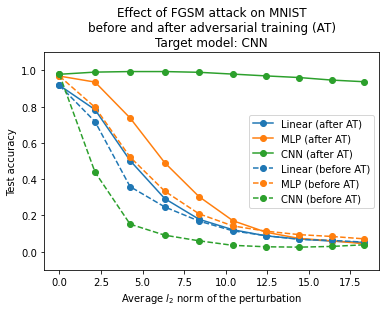

In [30]:
df_all = pd.read_csv('Post training Adversarial_Attacks_MNIST [FGSM Attack].csv')
df_CNN = df_all[df_all['Target model']=='CNN']
df_CNN = df_CNN.shift(1)
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_MNIST.evaluate(X_test[indexes],y_test[indexes]);
df_CNN.iloc[0] = ['-', '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df_CNN
plt.plot(df_CNN['avg_l2_norm'],df_CNN['Linear_MNIST_test_accuray'],'o-')
plt.plot(df_CNN['avg_l2_norm'],df_CNN['MLP_MNIST_test_accuray'],'o-')
plt.plot(df_CNN['avg_l2_norm'],df_CNN['CNN_MNIST_test_accuray'],'o-')

df_all = pd.read_csv('Adversarial_Attacks_MNIST [FGSM Attack].csv')
df_CNN = df_all[df_all['Target model']=='CNN']
df_CNN = df_CNN.shift(1)
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_MNIST.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_MNIST.evaluate(X_test[indexes],y_test[indexes]);
df_CNN.iloc[0] = ['-', '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df_CNN
plt.plot(df_CNN['avg_l2_norm'],df_CNN['Linear_MNIST_test_accuray'],'o--', color = 'C0')
plt.plot(df_CNN['avg_l2_norm'],df_CNN['MLP_MNIST_test_accuray'],'o--', color = 'C1')
plt.plot(df_CNN['avg_l2_norm'],df_CNN['CNN_MNIST_test_accuray'],'o--', color = 'C2')

plt.xlabel('Average $l_2$ norm of the perturbation')
plt.ylabel('Test accuracy')
plt.ylim([-0.1, 1.1])
# plt.legend(['CNN (after AT)', 'CNN (before AT)'])
plt.legend(['Linear (after AT)', 'MLP (after AT)','CNN (after AT)', \
            'Linear (before AT)', 'MLP (before AT)','CNN (before AT)'])
plt.title('Effect of FGSM attack on MNIST\nbefore and after adversarial training (AT)\nTarget model: CNN')
plt.savefig('Post training Effect of FGSM attack on MNIST for CNN model [l2 norm]', dpi=600)
plt.show()